# **Data Preprocessing Image Dataset**

This file takes the image dataset for lung cancer and creates several modified versions of the dataset to be used for model training and experiementing 

The choice of modifications is based on the analysis, the needs of different models and for experimental reasons

## Necessary Imports

In [26]:
# Python 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 
import sklearn
assert sklearn.__version__ >= "0.20"

# Pandas
import pandas as pd

import random

# Common imports
import numpy as np
import os
import cv2  

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Loading in original dataset aad scaling to same size

In [27]:
ROOT_PATH = os.path.join("..", "datasets", "3_image", "unprocessed", "Training cases")

# Define subfolders and their corresponding labels
folders_with_labels = {
    "Benign cases": "benign",
    "Malignant cases": "malignant",
    "Normal cases": "normal",
}

# Initialize lists to store image data and labels
image_data = []
labels = []

# Iterate through each folder and load image with labels
for folder, label in folders_with_labels.items():
    folder_path = os.path.join(ROOT_PATH, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust based on image format
            # Load the image in grayscale (adjust if needed)
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Store the image and its label
            image_data.append(image)
            labels.append(label)

# Convert to a DataFrame for easy manipulation
image_og_unbalanced = pd.DataFrame({
    "image": image_data,
    "label": labels
})

# Display the first few rows to verify
print(image_og_unbalanced.shape)
print(image_og_unbalanced.head())

(1097, 2)
                                               image   label
0  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
1  [[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, ...  benign
2  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
3  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
4  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign


#### Scaling images to same pixel width and height

In [28]:
def count_unique_image_sizes(df, image_column='image'):
    """
    Counts unique image sizes in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing images.
        image_column (str): The name of the column with image data.
        
    Returns:
        pd.DataFrame: A DataFrame with unique sizes and their counts.
    """
    # Initialize a list to store image sizes
    image_sizes = []

    # Loop through each image in the specified column
    for image in df[image_column]:
        # Get the shape of the image (height, width)
        height, width = image.shape
        # Append the size as a tuple
        image_sizes.append((height, width))

    # Convert the list to a DataFrame for easy counting and analysis
    size_df = pd.DataFrame(image_sizes, columns=['height', 'width'])

    # Count the unique sizes
    unique_sizes = size_df.value_counts().reset_index(name='count')

    return unique_sizes

# Display dimensions and counts of the images
unique_sizes_df = count_unique_image_sizes(image_og_unbalanced)
print("Unique image sizes and their counts:")
print(unique_sizes_df)


Unique image sizes and their counts:
   height  width  count
0     512    512   1036
1     512    623     31
2     512    801     28
3     331    506      1
4     404    511      1


In [29]:
# Define the target size
target_size = (512, 512)

# Resize each image to the target size
image_og_unbalanced['image'] = image_og_unbalanced['image'].apply(lambda img: cv2.resize(img, target_size, interpolation=cv2.INTER_AREA))

# Display dimensions and counts of the images
unique_sizes_df = count_unique_image_sizes(image_og_unbalanced)
print("Unique image sizes and their counts:")
print(unique_sizes_df)

Unique image sizes and their counts:
   height  width  count
0     512    512   1097


## Modifying dataset and saving as a file

#### Oversample to balance target class

In [30]:
image_og_unbalanced['label'].value_counts()

label
malignant    561
normal       416
benign       120
Name: count, dtype: int64

In [31]:
# Separate each class
normal_class = image_og_unbalanced[image_og_unbalanced['label'] == 'normal']
benign_class = image_og_unbalanced[image_og_unbalanced['label'] == 'benign']
malignant_class = image_og_unbalanced[image_og_unbalanced['label'] == 'malignant']  # Keeping malignant as-is since it's the majority class

# Oversample 'normal' and 'benign' classes to match the 'malignant' count of 561
normal_class_oversampled = normal_class.sample(n=561, replace=True, random_state=42)
benign_class_oversampled = benign_class.sample(n=561, replace=True, random_state=42)

# Combine the oversampled 'normal' and 'benign' instances with the original 'malignant' instances
image_og_balanced = pd.concat([malignant_class, normal_class_oversampled, benign_class_oversampled])

# Shuffle the dataset to mix the classes
image_og_balanced = image_og_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new counts
print(image_og_balanced['label'].value_counts())


label
benign       561
normal       561
malignant    561
Name: count, dtype: int64


The simplest method for oversampling was used - randomly duplicating instances. This is not ideal, however, the target class having equal value distributions could improve performance of certain models.

For all modified datasets both an oversampled (balanced) and unbalanced (original) version will be saved. The versions will be used that are best suited for the concrete machine learning models.

Note: in this case using oversamnpled dataset may lead to differeing results, as the imbalance of the normal class is only 1.3 compared to majority malignant, however, the benign class is heavily imbalanced, a ratio of 4.5. Model may trained on oversampled data may produce overly optimistic results and may not generalise well if oversampled dataset is used.


### 1 - original unmodified image with pixel values between 0 and 255

In [32]:
# Specify the folder path
SAVE_PATH = os.path.join("..", "datasets", "3_image", "processed")

# Specify file names (to be saved)
og_unbalanced_file_path = os.path.join(SAVE_PATH, "3_og_ub.csv")
og_balanced_file_path = os.path.join(SAVE_PATH, "3_og_b.csv")

# Check if the file already exists
if not os.path.exists(og_unbalanced_file_path):
    # Save the DataFrame if it doesn't exist
    image_og_unbalanced.to_csv(og_unbalanced_file_path, index=False)
    print(f"File saved at {og_unbalanced_file_path}")
else:
    print(f"File already exists at {og_unbalanced_file_path}")

# Repeat for balanced dataset 
if not os.path.exists(og_balanced_file_path):
    image_og_balanced.to_csv(og_balanced_file_path, index=False)
    print(f"File saved at {og_balanced_file_path}")
else:
    print(f"File already exists at {og_balanced_file_path}")

File saved at ../datasets/3_image/processed/3_og_ub.csv
File saved at ../datasets/3_image/processed/3_og_b.csv


### 2 - preprocessed and normalized

As followed from the image dataset analysis, the lung crossection covers different areas in different images and there are different background elements like noise in the background. It could have a positive impact on model performance if the important data from images is as consistent across the canvas area as possible with minimall noise variation. On top of that, it is common practice to normalize pixel values from range [0,255] to a range [0,1]

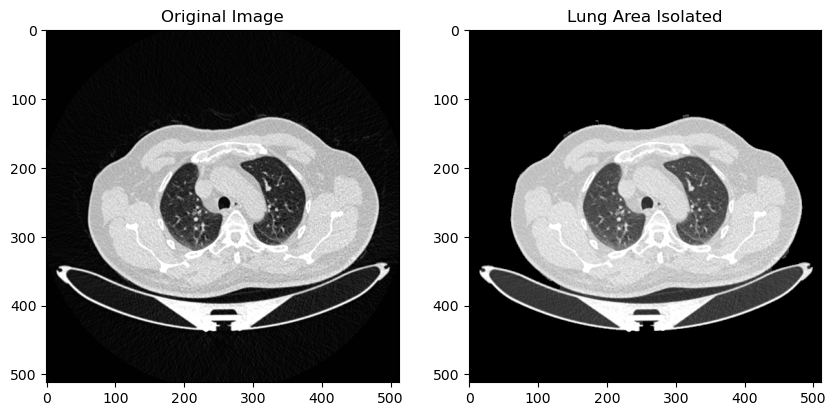

In [55]:
def isolate_lung_area(image):
    # Step 1: Convert to grayscale (if not already)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Step 2: Apply a threshold to create a binary image (adjust threshold if necessary)
    _, binary = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)

    # Step 3: Use morphological operations to remove small noise
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Step 4: Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5: Filter contours by area and choose the one likely to be the lung
    min_area = 10000  # Minimum area threshold (adjust as needed)
    max_area = 500000  # Maximum area threshold (adjust as needed)
    lung_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]
    largest_contour = max(lung_contours, key=cv2.contourArea) if lung_contours else None

    # Step 6: Create a mask with the largest contour filled in, if found
    lung_mask = np.zeros_like(binary)
    if largest_contour is not None:
        cv2.drawContours(lung_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Step 7: Apply the mask to the original grayscale image to keep only the lung area
    isolated_lung = cv2.bitwise_and(gray, gray, mask=lung_mask)

    return isolated_lung

# Example usage
# Load an example image (replace 'path_to_image' with the actual path)
image = cv2.imread('../datasets/3_image/unprocessed/Training cases/Benign cases/Bengin case (6).jpg', cv2.IMREAD_GRAYSCALE)
processed_image = isolate_lung_area(image)

# Display the original and processed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Lung Area Isolated")
plt.imshow(processed_image, cmap='gray')
plt.show()